## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pandas as pd
from pprint import pprint
import string
import os
import re
import numpy as np 
import pandas as pd 
import re
import nltk 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
import joblib
import seaborn as sns

In [ ]:
pd.set_option('display.max_columns', None) ## so that full columns are visible

## Helper Functions

In [ ]:
def format_float(value):
    return f'{value:,.2f}'

def find_agg(df:pd.DataFrame, agg_column:str, agg_metric:str, col_name:str, top:int, order=False )->pd.DataFrame:
    
    new_df = df.groupby(agg_column)[agg_column].agg(agg_metric).reset_index(name=col_name).\
                        sort_values(by=col_name, ascending=order)[:top]
    
    return new_df

def convert_bytes_to_megabytes(df, bytes_data):
    """
        This function takes the dataframe and the column which has the bytes values
        returns the megabytesof that value
        
        Args:
        -----
        df: dataframe
        bytes_data: column with bytes values
        
        Returns:
        --------
        A series
    """
    
    megabyte = 1*10e+5
    df[bytes_data] = df[bytes_data] / megabyte
    return df[bytes_data]

def fix_outlier(df, column):
    df[column] = np.where(df[column] > df[column].quantile(0.95), df[column].median(),df[column])
    
    return df[column]

def plot_hist(df:pd.DataFrame, column:str, color:str)->None:
    # plt.figure(figsize=(15, 10))
    # fig, ax = plt.subplots(1, figsize=(12, 7))
    sns.displot(data=df, x=column, color=color, kde=True, height=7, aspect=2)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

def plot_count(df:pd.DataFrame, column:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.countplot(data=df, x=column)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()
    
def plot_bar(df:pd.DataFrame, x_col:str, y_col:str, title:str, xlabel:str, ylabel:str)->None:
    plt.figure(figsize=(12, 7))
    sns.barplot(data = df, x=x_col, y=y_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks( fontsize=14)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.show()

def plot_heatmap(df:pd.DataFrame, title:str, cbar=False)->None:
    plt.figure(figsize=(12, 7))
    sns.heatmap(df, annot=True, cmap='viridis', vmin=0, vmax=1, fmt='.2f', linewidths=.7, cbar=cbar )
    plt.title(title, size=18, fontweight='bold')
    plt.show()

def plot_box(df:pd.DataFrame, x_col:str, title:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.boxplot(data = df, x=x_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.show()

def plot_box_multi(df:pd.DataFrame, x_col:str, y_col:str, title:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.boxplot(data = df, x=x_col, y=y_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks( fontsize=14)
    plt.show()

def plot_scatter(df: pd.DataFrame, x_col: str, y_col: str, title: str, hue: str, style: str) -> None:
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data = df, x=x_col, y=y_col, hue=hue, style=style)
    plt.title(title, size=20)
    plt.xticks(fontsize=14)
    plt.yticks( fontsize=14)
    plt.show()


pd.options.display.float_format = format_float

## Procedures 
1. Data loading
2. Data Cleaning
3. Data transforming
4. Data Extraction
5. EDA

### 1. Data Loading

In [ ]:
class DataLoader:
  def __init__(self,dir_name,file_name):
    self.dir_name = dir_name
    self.file_name = file_name
    
 
  def read_csv(self):
    os.chdir(self.dir_name)
    tweets_df=pd.read_csv(self.file_name)
    return tweets_df

data_loader_object = DataLoader('/content/drive/MyDrive/', 'Week1_challenge_data_source(CSV).csv')
raw_data = data_loader_object.read_csv()

### 2. Data Cleaning

In [ ]:
# Looking at the data
intermidate = raw_data.dropna()

In [ ]:
raw_data.columns.tolist().index("Handset Type")

30

In [ ]:
raw_data.columns.tolist().index("Social Media DL (Bytes)")

39

In [ ]:
columns = raw_data.columns.tolist()
columns = columns[columns.index("Handset Type")+1:columns.index("Social Media DL (Bytes)")]

In [ ]:
columns.append("Activity Duration DL (ms)")
columns.append("Activity Duration UL (ms)")

In [ ]:
new_data = raw_data[columns]

In [ ]:
new_new_data = new_data.dropna()

In [ ]:
new_new_data.shape

(18498, 10)

In [ ]:
columns

['Nb of sec with 125000B < Vol DL',
 'Nb of sec with 1250B < Vol UL < 6250B',
 'Nb of sec with 31250B < Vol DL < 125000B',
 'Nb of sec with 37500B < Vol UL',
 'Nb of sec with 6250B < Vol DL < 31250B',
 'Nb of sec with 6250B < Vol UL < 37500B',
 'Nb of sec with Vol DL < 6250B',
 'Nb of sec with Vol UL < 1250B',
 'Activity Duration DL (ms)',
 'Activity Duration UL (ms)']

In [ ]:
raw_data.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [ ]:
raw_data["DL TP > 1 Mbps (%)"][raw_data["DL TP > 1 Mbps (%)"] > 70].shape[0]

21

In [ ]:
print("Raws =", raw_data.shape[0], "   Columns", raw_data.shape[1])

Raws = 150001    Columns 55


In [ ]:
print(raw_data.columns)
print("column size", raw_data.columns.size)

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [ ]:
def percentage_missing(df):
  # Calculate total number of cells in dataframe
    totalCells = np.product(df.shape)

    # Count number of missing values per column
    missingCount = df.isna().sum()

    # Calculate total number of missing values
    totalMissing = missingCount.sum()

    # Calculate percentage of missing values
    print("The dataset is", round(((totalMissing/totalCells) * 100), 2), "%", "missing values.")

percentage_missing(raw_data)

The dataset is 12.5 % missing values.


In [ ]:
## About 12.5 is missing values, lets look at the columns with each count missing values
def columns_missing(df):
  # Get the missing value representation
  missing_bools = df.isna()

  missing_counts_per_column = []
  columns = list(missing_bools.columns)
  
  ## Find the missing count of each column so that we can view columns with
  ## large missing values
  for column in columns:
    missing_count = len(missing_bools[missing_bools[column] == True])
    print("Column", column, "has ", missing_count)
    missing_counts_per_column.append(missing_count)
    ret_val = list(zip(columns, missing_counts_per_column))
  
  ## sort using number of missing values
  ret_val.sort(key=lambda y: y[1])
  return ret_val


In [ ]:
# Drop columns where the missing values is above a certian threshold
def drop_columns(df, percentage_threshold):

  ## Get the column name with associated missing number of values
  missing_value_tuple_list = columns_missing(df);

  ## iterate through them and drop columns that have missing values beyond
  ## percentage threshold.
  for col_val in missing_value_tuple_list:
    length_of_col = len(df[col_val[0]])

    ## compare the size of column with size of missing values
    if col_val[1] >= percentage_threshold * length_of_col:
      print(col_val[0], col_val[1], length_of_col)
      df = df.drop(col_val[0], axis=1)
  return df


In [ ]:
# Looking at the data I decided the percentage threshold to be 30%
data_pr = drop_columns(raw_data, .3)

# We can now look at how much of the whole percentage is missing after droppnig
# some columns

percentage_missing(data_pr)

Column Bearer Id has  991
Column Start has  1
Column Start ms has  1
Column End has  1
Column End ms has  1
Column Dur. (ms) has  1
Column IMSI has  570
Column MSISDN/Number has  1066
Column IMEI has  572
Column Last Location Name has  1153
Column Avg RTT DL (ms) has  27829
Column Avg RTT UL (ms) has  27812
Column Avg Bearer TP DL (kbps) has  1
Column Avg Bearer TP UL (kbps) has  1
Column TCP DL Retrans. Vol (Bytes) has  88146
Column TCP UL Retrans. Vol (Bytes) has  96649
Column DL TP < 50 Kbps (%) has  754
Column 50 Kbps < DL TP < 250 Kbps (%) has  754
Column 250 Kbps < DL TP < 1 Mbps (%) has  754
Column DL TP > 1 Mbps (%) has  754
Column UL TP < 10 Kbps (%) has  792
Column 10 Kbps < UL TP < 50 Kbps (%) has  792
Column 50 Kbps < UL TP < 300 Kbps (%) has  792
Column UL TP > 300 Kbps (%) has  792
Column HTTP DL (Bytes) has  81474
Column HTTP UL (Bytes) has  81810
Column Activity Duration DL (ms) has  1
Column Activity Duration UL (ms) has  1
Column Dur. (ms).1 has  1
Column Handset Manu

In [ ]:
# There is a significant decrease of percentage missing. In retrospect,
# I shouldn't have deleted 'HTTP DL (Bytes)', 'HTTP UL (Bytes)', but they were 
# missing more than 50% of their values

In [ ]:
# Next lets analyse the the data left and fill the missings
columns_missing(data_pr)

Column Bearer Id has  991
Column Start has  1
Column Start ms has  1
Column End has  1
Column End ms has  1
Column Dur. (ms) has  1
Column IMSI has  570
Column MSISDN/Number has  1066
Column IMEI has  572
Column Last Location Name has  1153
Column Avg RTT DL (ms) has  27829
Column Avg RTT UL (ms) has  27812
Column Avg Bearer TP DL (kbps) has  1
Column Avg Bearer TP UL (kbps) has  1
Column DL TP < 50 Kbps (%) has  754
Column 50 Kbps < DL TP < 250 Kbps (%) has  754
Column 250 Kbps < DL TP < 1 Mbps (%) has  754
Column DL TP > 1 Mbps (%) has  754
Column UL TP < 10 Kbps (%) has  792
Column 10 Kbps < UL TP < 50 Kbps (%) has  792
Column 50 Kbps < UL TP < 300 Kbps (%) has  792
Column UL TP > 300 Kbps (%) has  792
Column Activity Duration DL (ms) has  1
Column Activity Duration UL (ms) has  1
Column Dur. (ms).1 has  1
Column Handset Manufacturer has  572
Column Handset Type has  572
Column Nb of sec with Vol DL < 6250B has  755
Column Nb of sec with Vol UL < 1250B has  793
Column Social Media D

[('Social Media DL (Bytes)', 0),
 ('Social Media UL (Bytes)', 0),
 ('Google DL (Bytes)', 0),
 ('Google UL (Bytes)', 0),
 ('Email DL (Bytes)', 0),
 ('Email UL (Bytes)', 0),
 ('Youtube DL (Bytes)', 0),
 ('Youtube UL (Bytes)', 0),
 ('Netflix DL (Bytes)', 0),
 ('Netflix UL (Bytes)', 0),
 ('Gaming DL (Bytes)', 0),
 ('Gaming UL (Bytes)', 0),
 ('Other DL (Bytes)', 0),
 ('Other UL (Bytes)', 0),
 ('Start', 1),
 ('Start ms', 1),
 ('End', 1),
 ('End ms', 1),
 ('Dur. (ms)', 1),
 ('Avg Bearer TP DL (kbps)', 1),
 ('Avg Bearer TP UL (kbps)', 1),
 ('Activity Duration DL (ms)', 1),
 ('Activity Duration UL (ms)', 1),
 ('Dur. (ms).1', 1),
 ('Total UL (Bytes)', 1),
 ('Total DL (Bytes)', 1),
 ('IMSI', 570),
 ('IMEI', 572),
 ('Handset Manufacturer', 572),
 ('Handset Type', 572),
 ('DL TP < 50 Kbps (%)', 754),
 ('50 Kbps < DL TP < 250 Kbps (%)', 754),
 ('250 Kbps < DL TP < 1 Mbps (%)', 754),
 ('DL TP > 1 Mbps (%)', 754),
 ('Nb of sec with Vol DL < 6250B', 755),
 ('UL TP < 10 Kbps (%)', 792),
 ('10 Kbps < UL 

In [ ]:
# I decided columns with less 10 percent missing values should be filled with
# interpolation. There will be some columns that will have values that cannot be
# filled like Bearer ID, IMEI, because of the fact they are unique, but we will
# resolve this during feature selection

In [ ]:
# I would like to interpolate and fill the numerical values and later drop ID and
# Unwanted columns
# Also I will drop raws where there is no handset manufacturer, handset type. This,
# will decrease the number of data points but hopefuly by not much. I want to use
# Bearer ID

In [ ]:
def remove_customers_with_no_bearer_id(df):
  index = df.index[df["Bearer Id"].isna()]
  df = df.drop(index, inplace=True)

remove_customers_with_no_bearer_id(data_pr)

# This removes customers with no bearer IDs, which is about 991 customers so
# no biggie

In [ ]:
# Looking at the data, I can also remove customers that have no handset-
# manufacturer, and handset type columns to make it easier for later use

def remove_customers_with_no_handset_man_type(df):
  ## remove customers with no handset manufacturer
  man_index = df.index[df["Handset Manufacturer"].isna()]
  df = df.drop(man_index, inplace=True)

  ## remove customers with no handset type
  # type_index = df.index[df["Handset Type"].isna()]
  # df = df.drop(type_index, inplace=True)

remove_customers_with_no_handset_man_type(data_pr)

In [ ]:
data_pr.index[data_pr["Handset Type"].isna()] ## this will return empty as we dropped the data

Int64Index([], dtype='int64')

In [ ]:
150001 - data_pr.shape[0] ## removed about 1002 data points

1002

In [ ]:
columns_missing(data_pr) ## Mostly nice looking numerical columns

Column Bearer Id has  0
Column Start has  0
Column Start ms has  0
Column End has  0
Column End ms has  0
Column Dur. (ms) has  0
Column IMSI has  0
Column MSISDN/Number has  493
Column IMEI has  0
Column Last Location Name has  162
Column Avg RTT DL (ms) has  27685
Column Avg RTT UL (ms) has  27666
Column Avg Bearer TP DL (kbps) has  0
Column Avg Bearer TP UL (kbps) has  0
Column DL TP < 50 Kbps (%) has  716
Column 50 Kbps < DL TP < 250 Kbps (%) has  716
Column 250 Kbps < DL TP < 1 Mbps (%) has  716
Column DL TP > 1 Mbps (%) has  716
Column UL TP < 10 Kbps (%) has  770
Column 10 Kbps < UL TP < 50 Kbps (%) has  770
Column 50 Kbps < UL TP < 300 Kbps (%) has  770
Column UL TP > 300 Kbps (%) has  770
Column Activity Duration DL (ms) has  0
Column Activity Duration UL (ms) has  0
Column Dur. (ms).1 has  0
Column Handset Manufacturer has  0
Column Handset Type has  0
Column Nb of sec with Vol DL < 6250B has  717
Column Nb of sec with Vol UL < 1250B has  771
Column Social Media DL (Bytes) ha

[('Bearer Id', 0),
 ('Start', 0),
 ('Start ms', 0),
 ('End', 0),
 ('End ms', 0),
 ('Dur. (ms)', 0),
 ('IMSI', 0),
 ('IMEI', 0),
 ('Avg Bearer TP DL (kbps)', 0),
 ('Avg Bearer TP UL (kbps)', 0),
 ('Activity Duration DL (ms)', 0),
 ('Activity Duration UL (ms)', 0),
 ('Dur. (ms).1', 0),
 ('Handset Manufacturer', 0),
 ('Handset Type', 0),
 ('Social Media DL (Bytes)', 0),
 ('Social Media UL (Bytes)', 0),
 ('Google DL (Bytes)', 0),
 ('Google UL (Bytes)', 0),
 ('Email DL (Bytes)', 0),
 ('Email UL (Bytes)', 0),
 ('Youtube DL (Bytes)', 0),
 ('Youtube UL (Bytes)', 0),
 ('Netflix DL (Bytes)', 0),
 ('Netflix UL (Bytes)', 0),
 ('Gaming DL (Bytes)', 0),
 ('Gaming UL (Bytes)', 0),
 ('Other DL (Bytes)', 0),
 ('Other UL (Bytes)', 0),
 ('Total UL (Bytes)', 0),
 ('Total DL (Bytes)', 0),
 ('Last Location Name', 162),
 ('MSISDN/Number', 493),
 ('DL TP < 50 Kbps (%)', 716),
 ('50 Kbps < DL TP < 250 Kbps (%)', 716),
 ('250 Kbps < DL TP < 1 Mbps (%)', 716),
 ('DL TP > 1 Mbps (%)', 716),
 ('Nb of sec with Vol 

In [ ]:
# Looking at the data there are two data types float64 and object,
# this means numbers are only represented in float64, thus easier for interpolation

def fill_missing_numerical_values(df):
  columns = df.columns
  for column in columns:
    if df[column].dtype == "float64":
      df[column] = df[column].interpolate()
  return df

In [ ]:
data_pr = fill_missing_numerical_values(data_pr)

#### Data Analysis - Task 1.0

In [ ]:
# Look at the unique sets of handsets used
def handsets_used(df, column):
  handsets = df[column].unique().tolist()
  return handsets

def visualize_use_of_handsets(df, column):
  labels = handsets_used(df, column)
  sizes = []
  for label in labels:
    size = df[df[column] == label].shape[0]
    sizes.append(size)
  fig1, ax1 = plt.subplots(figsize=(7,7))
  ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
  ax1.axis('equal')
  plt.show()

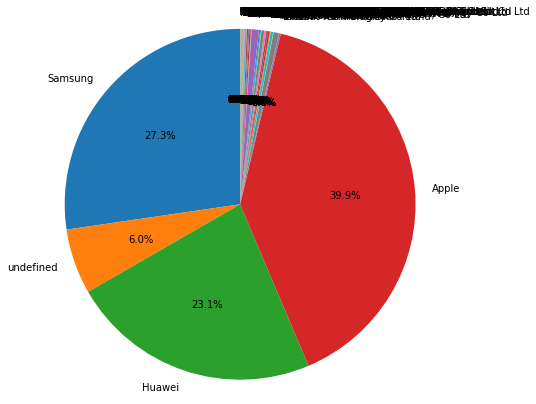

In [ ]:
visualize_use_of_handsets(data_pr, "Handset Manufacturer")

In [ ]:
# Looking at the above pie chart, it is not so clear as the data input is large,
# so we set limit to the top 10 handsets used
def visualize_use_of_handset(df, top_what, column):
  labels = handsets_used(df, column)
  total_handset = df[column].shape[0]
  percentage_left = 0
  sizes = []
  for label in labels:
    size = df[df[column] == label].shape[0]
    sizes.append(size)
  
  size_labels = list(zip(labels, sizes))
  size_labels.sort(key=lambda y: y[1], reverse=True)
  intermedate_zip = list(zip(*size_labels))
  new_labels, new_sizes = list(intermedate_zip[0]), list(intermedate_zip[1])
  new_labels, new_sizes = new_labels[:top_what], new_sizes[:top_what]

  percentage_left = sum(new_sizes)

  ## Add the remaining handsets as others
  new_labels.append("Others")
  new_sizes.append(total_handset-percentage_left)

  print(total_handset-percentage_left)
  fig1, ax1 = plt.subplots(figsize=(10,10))
  ax1.pie(new_sizes, labels=new_labels, autopct='%1.1f%%', startangle=90)
  ax1.axis('equal')
  plt.show()

44640


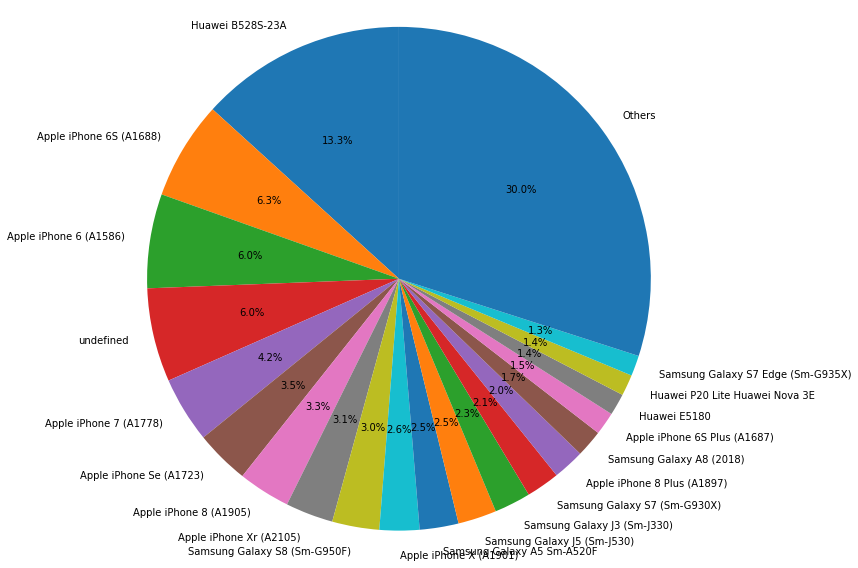

In [ ]:
# visualize the top 20 handsets used by customers
visualize_use_of_handset(data_pr, 20, "Handset Type")

14517


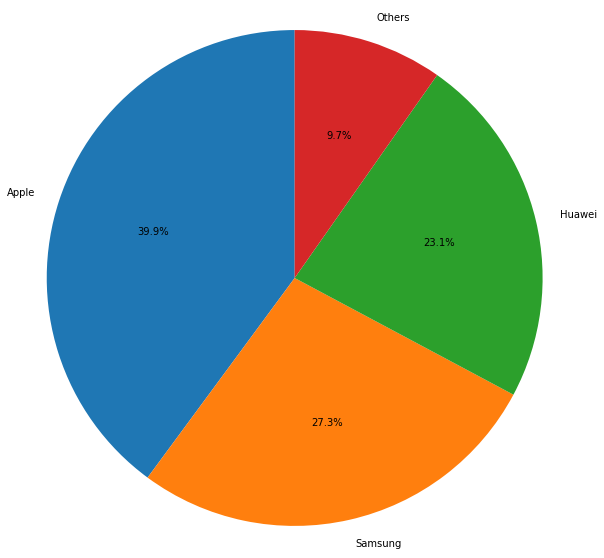

In [ ]:
# visualize the top 3 handset manufacturers
visualize_use_of_handset(data_pr, 3, "Handset Manufacturer")

In [ ]:
# visualize most used handsets in the three manufacturer type
def visaulize_types_per_manufacturer(df, manufacturer, handset_man, handsets, types_size):
  new_df = df[df[handset_man].str.contains(manufacturer)]
  labels = handsets_used(new_df, handsets)
  total_handset = new_df[handsets].shape[0]
  percentage_left = 0
  sizes = []
  for label in labels:
    size = new_df[new_df[handsets] == label].shape[0]
    sizes.append(size)
  
  size_labels = list(zip(labels, sizes))
  size_labels.sort(key=lambda y: y[1], reverse=True)
  intermedate_zip = list(zip(*size_labels))
  new_labels, new_sizes = list(intermedate_zip[0]), list(intermedate_zip[1])
  new_labels, new_sizes = new_labels[:types_size], new_sizes[:types_size]

  percentage_left = sum(new_sizes)

  ## Add the remaining handsets as others
  new_labels.append("Others")
  new_sizes.append(total_handset-percentage_left)

  print(total_handset-percentage_left)
  return new_labels, new_sizes

24573
22110
8035


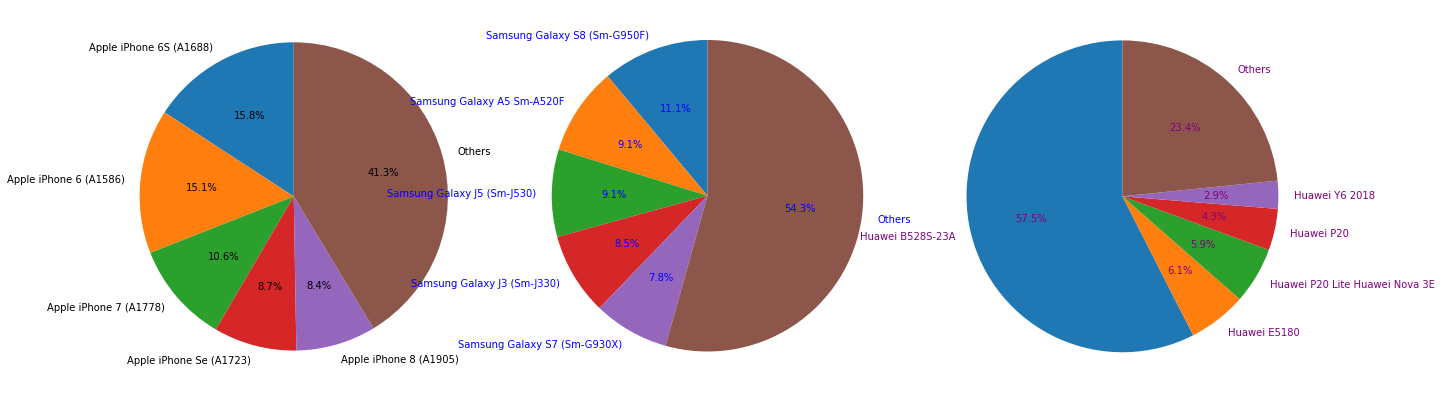

In [ ]:
iphone_label, iphone_size = visaulize_types_per_manufacturer(data_pr, "Apple", "Handset Manufacturer", "Handset Type", 5)
samsung_label, samsung_size = visaulize_types_per_manufacturer(data_pr, "Samsung", "Handset Manufacturer", "Handset Type", 5)
huwaei_label, huwaei_size = visaulize_types_per_manufacturer(data_pr, "Huawei", "Handset Manufacturer", "Handset Type", 5)
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(21,7))
ax1.pie(iphone_size, labels=iphone_label, autopct='%1.1f%%', startangle=90, textprops={'color':"black"})
ax2.pie(samsung_size, labels=samsung_label, autopct='%1.1f%%', startangle=90, textprops={'color':"blue"})
ax3.pie(huwaei_size, labels=huwaei_label, autopct='%1.1f%%', startangle=90, textprops={'color':"purple"})
ax1.axis('equal')
ax2.axis('equal') 
ax3.axis('equal') 
plt.show()

In [ ]:
data_pr.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),Activity Duration DL (ms),Activity Duration UL (ms),Dur. (ms).1,Handset Manufacturer,Handset Type,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,"13,114,483,460,844,900,352.00",4/4/2019 12:01,770.00,4/25/2019 14:35,662.00,"1,823,652.00","208,201,448,079,117.00","33,664,962,239.00","35,521,209,507,511.00",9.16456699548519E+015,42.00,5.00,23.00,44.00,100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,"37,624.00","38,787.00","1,823,652,892.00",Samsung,Samsung Galaxy A5 Sm-A520F,213.00,214.00,"1,545,765.00","24,420.00","1,634,479.00","1,271,433.00","3,563,542.00","137,762.00","15,854,611.00","2,501,332.00","8,198,936.00","9,656,251.00","278,082,303.00","14,344,150.00","171,744,450.00","8,814,393.00","36,749,741.00","308,879,636.00"
1,"13,114,483,482,878,900,224.00",4/9/2019 13:04,235.00,4/25/2019 8:15,606.00,"1,365,104.00","208,201,909,211,140.00","33,681,854,413.00","35,794,009,006,359.00",L77566A,65.00,5.00,16.00,26.00,100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,168.00,"3,560.00","1,365,104,371.00",Samsung,Samsung Galaxy J5 (Sm-J530),971.00,"1,022.00","1,926,113.00","7,165.00","3,493,924.00","920,172.00","629,046.00","308,339.00","20,247,395.00","19,111,729.00","18,338,413.00","17,227,132.00","608,750,074.00","1,170,709.00","526,904,238.00","15,055,145.00","53,800,391.00","653,384,965.00"
2,"13,114,483,484,080,500,736.00",4/9/2019 17:42,1.00,4/25/2019 11:58,652.00,"1,361,762.00","208,200,314,458,056.00","33,760,627,129.00","35,281,510,359,387.00",D42335A,72.40,5.00,6.00,9.00,100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,"1,361,762,651.00",Samsung,Samsung Galaxy A8 (2018),751.00,695.00,"1,684,053.00","42,224.00","8,535,055.00","1,694,064.00","2,690,151.00","672,973.00","19,725,661.00","14,699,576.00","17,587,794.00","6,163,408.00","229,584,621.00","395,630.00","410,692,588.00","4,215,763.00","27,883,638.00","279,807,335.00"
3,"13,114,483,485,442,799,616.00",4/10/2019 0:31,486.00,4/25/2019 7:36,171.00,"1,321,509.00","208,201,402,342,131.00","33,750,343,200.00","35,356,610,164,913.00",T21824A,79.80,5.00,44.00,44.00,100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,"3,330.00","37,882.00","1,321,509,685.00",undefined,undefined,17.00,207.00,"644,121.00","13,372.00","9,023,734.00","2,788,027.00","1,439,754.00","631,229.00","21,388,122.00","15,146,643.00","13,994,646.00","1,097,942.00","799,538,153.00","10,849,722.00","749,039,933.00","12,797,283.00","43,324,218.00","846,028,530.00"
4,"13,114,483,499,480,700,928.00",4/12/2019 20:10,565.00,4/25/2019 10:40,954.00,"1,089,009.00","208,201,401,415,120.00","33,699,795,932.00","35,407,009,745,539.00",D88865A,87.20,5.00,6.00,9.00,100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,"1,089,009,389.00",Samsung,Samsung Sm-G390F,607.00,604.00,"862,600.00","50,188.00","6,248,284.00","1,500,559.00","1,936,496.00","173,853.00","15,259,380.00","18,962,873.00","17,124,581.00","415,218.00","527,707,248.00","3,529,801.00","550,709,500.00","13,910,322.00","38,542,814.00","569,138,589.00"


In [ ]:
data_pr["Total UL+DL"] = data_pr["Total UL (Bytes)"] + data_pr["Total DL (Bytes)"]
data_pr["Social UL+DL"] = data_pr["Social Media UL (Bytes)"] + data_pr["Social Media DL (Bytes)"]
data_pr["Google UL+DL"] = data_pr["Google UL (Bytes)"] + data_pr["Google DL (Bytes)"]
data_pr["Youtube UL+DL"] = data_pr["Youtube UL (Bytes)"] + data_pr["Youtube DL (Bytes)"]
data_pr["Netflix UL+DL"] = data_pr["Netflix UL (Bytes)"] + data_pr["Netflix DL (Bytes)"]
data_pr["Gaming UL+DL"] = data_pr["Gaming UL (Bytes)"] + data_pr["Gaming DL (Bytes)"]

In [ ]:
data_pr.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),Activity Duration DL (ms),Activity Duration UL (ms),Dur. (ms).1,Handset Manufacturer,Handset Type,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes),Total UL+DL,Social UL+DL,Google UL+DL,Youtube UL+DL,Netflix UL+DL,Gaming UL+DL
0,"13,114,483,460,844,900,352.00",4/4/2019 12:01,770.00,4/25/2019 14:35,662.00,"1,823,652.00","208,201,448,079,117.00","33,664,962,239.00","35,521,209,507,511.00",9.16456699548519E+015,42.00,5.00,23.00,44.00,100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,"37,624.00","38,787.00","1,823,652,892.00",Samsung,Samsung Galaxy A5 Sm-A520F,213.00,214.00,"1,545,765.00","24,420.00","1,634,479.00","1,271,433.00","3,563,542.00","137,762.00","15,854,611.00","2,501,332.00","8,198,936.00","9,656,251.00","278,082,303.00","14,344,150.00","171,744,450.00","8,814,393.00","36,749,741.00","308,879,636.00","345,629,377.00","1,570,185.00","2,905,912.00","18,355,943.00","17,855,187.00","292,426,453.00"
1,"13,114,483,482,878,900,224.00",4/9/2019 13:04,235.00,4/25/2019 8:15,606.00,"1,365,104.00","208,201,909,211,140.00","33,681,854,413.00","35,794,009,006,359.00",L77566A,65.00,5.00,16.00,26.00,100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,168.00,"3,560.00","1,365,104,371.00",Samsung,Samsung Galaxy J5 (Sm-J530),971.00,"1,022.00","1,926,113.00","7,165.00","3,493,924.00","920,172.00","629,046.00","308,339.00","20,247,395.00","19,111,729.00","18,338,413.00","17,227,132.00","608,750,074.00","1,170,709.00","526,904,238.00","15,055,145.00","53,800,391.00","653,384,965.00","707,185,356.00","1,933,278.00","4,414,096.00","39,359,124.00","35,565,545.00","609,920,783.00"
2,"13,114,483,484,080,500,736.00",4/9/2019 17:42,1.00,4/25/2019 11:58,652.00,"1,361,762.00","208,200,314,458,056.00","33,760,627,129.00","35,281,510,359,387.00",D42335A,72.40,5.00,6.00,9.00,100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,"1,361,762,651.00",Samsung,Samsung Galaxy A8 (2018),751.00,695.00,"1,684,053.00","42,224.00","8,535,055.00","1,694,064.00","2,690,151.00","672,973.00","19,725,661.00","14,699,576.00","17,587,794.00","6,163,408.00","229,584,621.00","395,630.00","410,692,588.00","4,215,763.00","27,883,638.00","279,807,335.00","307,690,973.00","1,726,277.00","10,229,119.00","34,425,237.00","23,751,202.00","229,980,251.00"
3,"13,114,483,485,442,799,616.00",4/10/2019 0:31,486.00,4/25/2019 7:36,171.00,"1,321,509.00","208,201,402,342,131.00","33,750,343,200.00","35,356,610,164,913.00",T21824A,79.80,5.00,44.00,44.00,100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,"3,330.00","37,882.00","1,321,509,685.00",undefined,undefined,17.00,207.00,"644,121.00","13,372.00","9,023,734.00","2,788,027.00","1,439,754.00","631,229.00","21,388,122.00","15,146,643.00","13,994,646.00","1,097,942.00","799,538,153.00","10,849,722.00","749,039,933.00","12,797,283.00","43,324,218.00","846,028,530.00","889,352,748.00","657,493.00","11,811,761.00","36,534,765.00","15,092,588.00","810,387,875.00"
4,"13,114,483,499,480,700,928.00",4/12/2019 20:10,565.00,4/25/2019 10:40,954.00,"1,089,009.00","208,201,401,415,120.00","33,699,795,932.00","35,407,009,745,539.00",D88865A,87.20,5.00,6.00,9.00,100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,"1,089,009,389.00",Samsung,Samsung Sm-G390F,607.00,604.00,"862,600.00","50,188.00","6,248,284.00","1,500,559.00","1,936,496.00","173,853.00","15,259,380.00","18,962,873.00","17,124,581.00","415,

#### Data Analysis - Task 1.1

In [ ]:
# First we need to get what xDR is
# xDR is a collection of the session WRT Social Media, 
# Google, Email, Youtube, Netflix, Gaming, Other . 
data_pr.head(5)

In [ ]:
# Aggregate per user the following information in the column  
# 1. number of xDR sessions
# 2. Session duration
# 3. the total download (DL) and upload (UL) data
# 4. the total data volume (in Bytes) during this session for each application

# The above informations are used as columns

columns = ["Bearer Id", "number of xDR sessions", "Session Duration", "Total DL", "Total UL", "Total vol social", "Total vol google", 
           "Total vol youtube", "Total vol netflix", "Total vol gaming", "Total vol other"]
data_purged = pd.DataFrame(columns=columns)

In [ ]:
data_purged["Bearer Id"] = data_pr["Bearer Id"].unique()

In [ ]:
# data_purged["Bearer Id"] = data_pr["Bearer Id"].unique()
nXDR, sD, TDl, TUl, TVS, TVY, TVG, TVN, TVGa, TVO = [],[],[],[],[],[],[],[],[],[]
for unique_id in data_purged["Bearer Id"]:
  nXDR.append(len(data_pr[data_pr["Bearer Id"] == unique_id]))
  sD.append(data_pr["Dur. (ms)"][data_pr["Bearer Id"] == unique_id].sum())
  TDl.append(data_pr["Total DL (Bytes)"][data_pr["Bearer Id"] == unique_id].sum())
  TUl.append(data_pr["Total UL (Bytes)"][data_pr["Bearer Id"] == unique_id].sum())
  TVS.append(data_pr["Social Media UL (Bytes)"][data_pr["Bearer Id"] == unique_id].sum() + data_pr["Social Media DL (Bytes)"][data_pr["Bearer Id"] == unique_id].sum())
  TVY.append(data_pr["Youtube UL (Bytes)"][data_pr["Bearer Id"] == unique_id].sum() + data_pr["Youtube DL (Bytes)"][data_pr["Bearer Id"] == unique_id].sum())
  TVG.append(data_pr["Google UL (Bytes)"][data_pr["Bearer Id"] == unique_id].sum() + data_pr["Google DL (Bytes)"][data_pr["Bearer Id"] == unique_id].sum())
  TVN.append(data_pr["Netflix UL (Bytes)"][data_pr["Bearer Id"] == unique_id].sum() + data_pr["Netflix DL (Bytes)"][data_pr["Bearer Id"] == unique_id].sum())
  TVG.append(data_pr["Gaming UL (Bytes)"][data_pr["Bearer Id"] == unique_id].sum() + data_pr["Gaming DL (Bytes)"][data_pr["Bearer Id"] == unique_id].sum())
  TVO.append(data_pr["Other UL (Bytes)"][data_pr["Bearer Id"] == unique_id].sum() + data_pr["Other DL (Bytes)"][data_pr["Bearer Id"] == unique_id].sum())

#### NEVER EXCUTE THIS IT takes 17 minutes

In [ ]:
data_purged["number of xDR sessions"] = nXDR
data_purged["Session Duration"] = sD
data_purged["Total DL"] = TDl
data_purged["Total UL"] = TUl
data_purged['Total vol social'] = TVS
data_purged['Total vol youtube'] = TVY
data_purged['Total vol google'] = TVG[:134697]
data_purged['Total vol netflix'] = TVN
data_purged['Total vol gaming'] = TVG[134697:]
data_purged['Total vol other'] = TVO
  

#### Data Analysis - Task 1.3

In [ ]:
data_purged = pd.read_csv('data_purged.csv')

##### Standardizing and Normalizing

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

minmax_scaler = MinMaxScaler()

# generate 1000 data points randomly drawn from an exponential distribution
# mix-max scale the data between 0 and 1
def scaler(df):
    scaled_data = minmax_scaler.fit_transform(df)

    # plot both together to compare
    fig, ax = plt.subplots(1,2, figsize=(10, 6))
    sns.histplot(df, ax=ax[0])
    ax[0].set_title("Original Data")
    sns.histplot(scaled_data, ax=ax[1])
    ax[1].set_title("Scaled data")
    

def normalizer(df):
    norm = Normalizer()
    # normalize the exponential data with boxcox
    normalized_data = norm.fit_transform(df)

    # plot both together to compare
    fig, ax=plt.subplots(1,2, figsize=(10, 6))
    sns.histplot(df, ax=ax[0])
    ax[0].set_title("Original Data")
    sns.histplot(normalized_data[0], ax=ax[1])
    ax[1].set_title("Normalized data")

In [ ]:
bearer_id_holder = data_purged["Bearer Id"]
data_purged.drop(["Bearer Id"], axis=1, inplace=True)
data_purged.head()

In [ ]:
scaler(data_purged)
normalizer(data_purged)

In [ ]:
data_purged.insert(0, "Bearer Id" ,bearer_id_holder)

In [ ]:
data_purged.head()

##### 1. Basic central tendencies (Mean, Median and, Mode)

In [ ]:
columns = ["Mean", "Median", "Mode"]
indexs = ["number of xDR sessions", "Session Duration", "Total DL", "Total UL",
          'Total vol social', 'Total vol youtube', 'Total vol google', 
          'Total vol netflix', 'Total vol gaming', 'Total vol other']
central_tendency = pd.DataFrame(columns=columns, index=indexs)

In [ ]:
central_tendency["Mode"] = [data_purged[modes].mode() for modes in data_purged.columns][1:]

In [ ]:
central_tendency["Median"] = data_purged.median()

In [ ]:
central_tendency["Mean"] = data_purged.mean()

In [ ]:
central_tendency

##### 2. Measures of dispersion

In [ ]:
# The main measures of dispersion -  standard deviation, variance
columns = ["Variance", "Standard Devation"]
dispersion = pd.DataFrame(columns=columns, index=indexs)

In [ ]:
dispersion["Variance"] = data_purged.var()[1:]

In [ ]:
dispersion["Standard Devation"] = data_purged.std()[1:]

In [ ]:
dispersion

##### 3. Graphical univariate analysis 

In [ ]:
plot_hist(data_purged, "Total DL", "blue")

In [ ]:
plot_hist(data_purged, "Total UL", "green")

In [ ]:
plot_hist(data_purged, "Session Duration", "cyan")

In [ ]:
# Check outliers
plot_box(data_purged, "Total DL", "Total UL outliers")

In [ ]:
# Total vol social', 'Total vol youtube', 'Total vol google', 
#           'Total vol netflix', 'Total vol gaming', 'Total vol other'

In [ ]:
plot_hist(data_purged, "Total vol social", "yellow")

In [ ]:
plot_hist(data_purged, "Total vol youtube", "magenta")

In [ ]:
plot_hist(data_purged, "Total vol google", "gray")

In [ ]:
plot_hist(data_purged, "Total vol netflix", "lightgreen")

##### Bivariate Analysis

In [ ]:
# Handset Manufacturer
plot_scatter(data_pr.head(100), x_col="Total UL+DL", y_col="Social UL+DL", hue="Handset Manufacturer",
              style=None, title="Total UL+DL vs Social Media")

In [ ]:
plot_scatter(data_pr.head(100), x_col="Total UL+DL", y_col="Youtube UL+DL", hue="Handset Manufacturer",
              style=None, title="Total UL+DL vs Youtube")

In [ ]:
plot_scatter(data_pr.head(100), x_col="Total UL+DL", y_col="Netflix UL+DL", hue="Handset Manufacturer",
              style=None, title="Total UL+DL vs Netflix")

In [ ]:
plot_scatter(data_pr.head(100), x_col="Total UL+DL", y_col="Gaming UL+DL", hue="Handset Manufacturer",
              style=None, title="Total UL+DL vs Gaming")

##### Variable translations

In [ ]:
# First arrange based on total volume
data_arranged = data_pr.sort_values(by="Total UL+DL", ascending=False)

In [ ]:
top_five_decile_dataframes = np.array_split(data_arranged[:148990], 10)[:5] # dropped last 10 element to make it decile

In [ ]:
total_duration_for_top_five = [decile_class["Total UL+DL"].sum() for decile_class in top_five_decile_dataframes]

In [ ]:
total_duration_for_top_five

##### 5. Correlation Matrix

In [ ]:
columns = ["Social UL+DL",	"Google UL+DL",	"Youtube UL+DL",	"Netflix UL+DL",	"Gaming UL+DL"]
data_for_conf = data_pr[columns]

In [ ]:
correlation_matrix = data_for_conf.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

##### Dimentionality Reduction

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [ ]:
# fit the data to 2D
data_2d = pca.fit_transform(data_for_conf)

In [ ]:
# Explaining variance ratio
pca.explained_variance_ratio_

In [ ]:
# Variance lost
1 - pca.explained_variance_ratio_.sum()

In [ ]:
# 1.1% variance lost for the whole transformation

In [ ]:
data_2d